In [2]:
import numpy as np
import pandas as pd
import math

from typing import Tuple
import src.hdmm.workload as workload
import src.census_workloads as census
from src.workload_selection import workload_selection
import online_workloads as online_workloads
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(font_scale=2)
sns.set_style("white")

In [4]:
n=64
W_name = ['identity', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']#, 'total',]
W_lst = [online_workloads.identity(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n),] # online_workloads.total(n),]

In [5]:
def pmw_naive(workload, x, analyst_labels, T, eps=0.01, total_k=None, 
         show_messages=False, to_return='error', show_plot=False, show_failure_step=False, eta = None,
             count_threshold=0.1):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries where analysts can run out of privacy budget if they use too much of others'. 
    
    In other words, all analysts share from the same privacy budget. 
    
    Last Updated: 4-23-2022

    Algorithm Parameters: 
    - workload = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - T = update threshold
    - eps = privacy budget
    - total_k = total number of update steps alloted for the entire group
    - analyst_labels = list of analyst names corresponding to each query in the workload
    
    Output Controls: 
    - show_messages argument determines whether the function will print information such as 
    error scale, threshold, update steps used, etc.
    - to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query in the workload(showing query, d_t_hat, updated, algo_ans, real_ans, 
        abs_error, rel_error). 
        - if 'error', pmw() returns a dictionary for the average absolute error for each analyst
        - if 'pct_ans', pmw() returns a dictionary for the percent of queries answered that meets
        the accuracy threshold set by count_threshold
    - show_plot - T/F whether the function will display a plot
    - show_failure_step - T/F whether function prints what step failure mode is reached
    - count_threshold - this is for the to_return = 'pct_ans' setting. It is the min error threshold 
    that a query answer for us to count the answer as "reasonable" as opposed to "bot". The default
    is 0.1. This functions as another way to  measure the accuracy of the queries that is more similar 
    to how our other functions; i.e., cache and reconstruct either returns an accurate answer or "bot".
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if(eta == None):
        eta = (math.log(m, np.e) / ((math.sqrt(n))) )
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    
    # initialize synthetic databases at time 0 (prior to any queries)
    x_t = np.ones(m) / m
    y_t = np.ones(m) / m

    # initialize tracker lists to construct pandas dataframe at the end 
    x_list = [x_t] # create a list of x_t synthetic database at every time step
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = [] # record times that database is updated
    d_t_hat_list = []
    
    # initialize total_k, the total number of update steps if not default
    if total_k == None:
        total_k = round(n * math.log(math.sqrt(m)) / 770) #770
        #print(f'{total_k=}')
    
    def lazy_round():
        """
        "Lazy Round" of querying using the stored synthetic database, x_t, in list x_list.
        
        We call this the lazy round because it is contrasted with the updated step where we update the 
        sythetic database and answer the query using the real database.
        """
        update_list.append('no')
        answer = np.dot(query, x_list[time])
        if answer < 0:
            pmw_answers.append(0)
        else: 
            pmw_answers.append(answer)
        x_list.append(x_list[time])
    
    # inititate first instance of SVT with half the budget and k updates; will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 = ((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    #print(rho + T)
    
    
    for time, query in enumerate(workload):
        
        analyst = analyst_labels[time]
        
        # Do one round of sparse vector technique; compute noisy answer by adding Laplacian noise
        A_t = np.random.laplace(loc=0, scale=(total_k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + A_t
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # LAZY ROUND: QUERY USING THE SYNTHETIC DATABASE
        if (abs(d_t_hat) <= T + rho):
            d_t_hat_list.append(d_t_hat)
            lazy_round()

        # UPDATE ROUND: UPDATE SYNTHETIC DATABASE AND RETURN NOISY ANSWER, A_T-HAT
        else:
            # noise
            A_t = np.random.laplace(loc=0, scale=(2*total_k/eps), size=1)[0]
            
            # noisy answer
            a_t_hat = (np.dot(query, x_norm)*n ) + A_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            update_times.append(time)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i in range(len(y_t)):
                y_t[i] = x_list[time][i] * math.exp(-( eta * r_t[i]))# eta is the learning rate
            
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            # if threshold for num updates is reached, just do a lazy round (synthetic database) answer
            if total_k == 0: 
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
                
            # if there are still update steps that the analyst can use, 
            # 1. update the synthetic database
            # 2. answer the query using the noisy answer from the database itself 
            else: 
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                answer = a_t_hat / np.sum(x)
                
                if answer < 0:
                    pmw_answers.append(0)
                else: 
                    pmw_answers.append(answer)
                
                total_k -= 1 # use one of the total update steps
        
        #print(f'{x_list[time] - x_list[time - 1]=}')
        
        
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    if show_messages:
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Synthetic Database (after) = {x_list[len(x_list) - 1] * sum(x)}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Synthetic Database (before) = {x_list[0]}\n')
        print(f'Synthetic Database (after, norm) = {x_list[len(x_list) - 1]}\n')
        print(f'Difference btw. Final Synthetic and true database = {x_list[len(x_list) - 1] - x_norm}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*total_k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*total_k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
        
    if show_plot: 
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line,rel_line])
        plt.xticks(range(0, len(workload), round(len(workload)/5)))
    
    if to_return == "pd":
        # hacky fix: remove the first synthetic database to keep length of lists consistent with the
        # other lists that comprise of the pandas dataframe
        x_list.pop(0).tolist() 
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        #test_data = test_data.round(3)
        return test_data
    
    if to_return == "error":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,               
             'rel_error': rel_error,}
        data = pd.DataFrame(data=d)
        data = data.round(3)
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "tse":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        data['squared_err'] = data['abs_error'] ** 2
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "pct_ans":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        
        pct_answered = {}
        for analyst in sorted(list(set(analyst_labels))):
            pct_answered[analyst] = data[(data['abs_error'] < count_threshold) & 
                                         (data.analyst==analyst)]['abs_error'].count()/len(data[data.analyst==analyst]) * 100
        return pct_answered

In [6]:
data_path = "migration_tworace.csv"
x_race = pd.read_csv(data_path, header=None).to_numpy().T[1] # truncate to first 64
x_race

array([412, 333, 285, 231, 202, 174, 160, 142, 146, 149, 145, 181, 174,
       190, 213, 287, 372, 499, 619, 715, 785, 821, 822, 816, 799, 742,
       717, 697, 658, 593, 564, 519, 447, 403, 388, 365, 336, 306, 311,
       289, 261, 231, 213, 196, 194, 170, 175, 168, 149, 142, 131, 119,
       112, 118, 114, 116, 112, 114, 106, 111, 109, 112, 113, 109, 104,
       108, 108,  94,  91,  81,  81,  72,  68,  63,  56,  46,  41,  38,
        34,  28,  23,  22,  18,  18,  16,  41])

In [7]:
def skewed_scheduler(a: np.ndarray, b: np.ndarray, p: int) -> Tuple: 
    """
    Schedules Alice's queries with a probability of p and Bob's queries with a probability of (p - 1).
    
    Returns new workload of queries (2x2 np.array) and analyst labels (python list). 
    
    p: prob of scheduling Alice's queries
    a: alice's workload
    b: bob's workload
    """
    
    W = []
    analyst_labels = []
    
    if a.shape[1] != b.shape[1]:
         raise TypeError("a and b dimensions don't match")
    
    a_pointer = 0
    b_pointer = 0
    
    while(a_pointer < len(a) and b_pointer < len(b)):
        if np.random.random() < p:
            W.append(a[a_pointer])
            a_pointer += 1
            analyst_labels.append('A')
        else: 
            W.append(b[b_pointer])
            b_pointer += 1
            analyst_labels.append('B')
    
    if a_pointer == len(a):
        W = np.vstack((W, b[b_pointer:]))
        analyst_labels += ['B' for i in range(b_pointer, len(b))]
    if b_pointer == len(b): 
        W = np.vstack((W, a[a_pointer:]))
        analyst_labels += ['A' for i in range(a_pointer, len(a))]
    
    W = np.array(W)
    return W, analyst_labels

a_ex = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])

b_ex = np.array([[11, 22, 33],
             [44, 55, 66],
             [77, 88, 99]])
    
skewed_scheduler(a_ex, b_ex, 0.5)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [11, 22, 33],
        [ 7,  8,  9],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'B', 'A', 'B', 'B'])

In [8]:
def get_max_ratio_df(version='practical', iterations=3000, input_thresh = 0.05, mode='utility'):
    """
    Run experiments using calc_max_ratio. 
    
    version = type of workloads
        practical: practical workloads from hdmm paper
        disjoint: random disjoint workloads
    
    mode = 
        utility: refers to pct of queries answerable
        error: refers to the pct of queries unanswerable 
        error_val: refers to the exact error values of the queries from pmw
    
    date: may-1, last edited may-4
    """
    BwA_lst = []
    BwoA_lst = []
    AwB_lst = []
    AwoB_lst = []
    max_ratio_p_lst = []
    
    def calc_max_ratio(p, thresh = 0.03, workload='practical'):
        """
        Calculate max ratio using appending to lists. 

        May 1
        """

        #database = x_race[:64]
        database = np.concatenate([x_race[:32], x_race[:32]])

        if workload=='practical':
            c = np.random.randint(len(W_lst))

            alice = W_lst[c]
            bob = W_lst[c]

        elif workload=='disjoint':
            random_array = np.random.randint(2, size=(100,32))
            zero_array = np.zeros((100,32))
            alice = np.hstack((random_array, zero_array))
            bob = np.hstack((zero_array, random_array))
        
        # skewed scheduler
        W, analyst_labels = skewed_scheduler(alice, bob, p)
        
        if mode=='error_val':
            BwA = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='error', count_threshold=thresh)['B']

            AwB = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='error', count_threshold=thresh)['A']

            # bob ind
            BwoA = pmw_naive(bob, database, ['B'] * len(bob), eps=0.5, T=20, to_return='error', count_threshold=thresh)['B']

            # alice ind
            AwoB = pmw_naive(bob, database, ['A'] * len(alice), eps=0.5, T=20, to_return='error', count_threshold=thresh)['A']
            
            if(AwoB != 0 and BwoA != 0):
                if mode=='utility':        
                    # prevent divide by 0 error, ignore
                    max_ratio_p_lst.append(p)
                    BwA_lst.append(BwA)
                    BwoA_lst.append(BwoA)
                    AwB_lst.append(AwB)
                    AwoB_lst.append(AwoB)
        else: 
            BwA = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='pct_ans', count_threshold=thresh)['B']

            AwB = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='pct_ans', count_threshold=thresh)['A']

            # bob ind
            BwoA = pmw_naive(bob, database, ['B'] * len(bob), eps=0.5, T=20, to_return='pct_ans', count_threshold=thresh)['B']

            # alice ind
            AwoB = pmw_naive(bob, database, ['A'] * len(alice), eps=0.5, T=20, to_return='pct_ans', count_threshold=thresh)['A']

            if(AwoB != 0 and BwoA != 0):
                if mode=='utility':        
                    # prevent divide by 0 error, ignore
                    max_ratio_p_lst.append(p)
                    BwA_lst.append(BwA)
                    BwoA_lst.append(BwoA)
                    AwB_lst.append(AwB)
                    AwoB_lst.append(AwoB)
                if mode=='error':        
                    # prevent divide by 0 error, ignore
                    max_ratio_p_lst.append(p)
                    BwA_lst.append(100 - BwA)
                    BwoA_lst.append(100 - BwoA)
                    AwB_lst.append(100 - AwB)
                    AwoB_lst.append(100 - AwoB)
                

    for i in range(iterations):
        if i in list(range(0, 3001, 50)): 
            print(f'{i} iterations have passed')
        for p in [i / 100 for i in range(50, 101, 10)]:
            calc_max_ratio(p, thresh=input_thresh, workload=version)

    df_max_ratio = pd.DataFrame(list(zip(max_ratio_p_lst, BwA_lst, BwoA_lst, AwB_lst, AwoB_lst)), 
                                             columns =['p', 'BwA', 'BwoA', 'AwB', 'AwoB'])
    return df_max_ratio

# Disjoint Max Ratio Error
Date: May-4

In [12]:
df_max_ratio_disjoint = get_max_ratio_df(version='disjoint', 
                                         iterations=300, 
                                         input_thresh = 0.001, 
                                         mode='error')

0 iterations have passed
50 iterations have passed
100 iterations have passed
150 iterations have passed
200 iterations have passed
250 iterations have passed


In [13]:
# remove zeros
df_max_ratio_disjoint = df_max_ratio_disjoint[(df_max_ratio_disjoint != 0).all(1)]

df_max_ratio_disjoint['A_MRE'] = df_max_ratio_disjoint['AwB'] / df_max_ratio_disjoint['AwoB']
df_max_ratio_disjoint['B_MRE'] = df_max_ratio_disjoint['BwA'] / df_max_ratio_disjoint['BwoA']

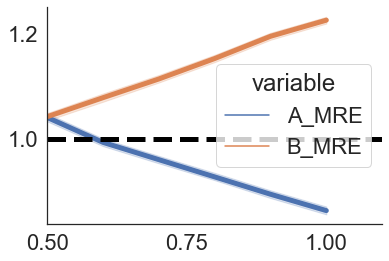

In [14]:
df_MRE = pd.melt(df_max_ratio_disjoint, id_vars='p', 
                 #value_vars=['AwB', 'AwoB', 'BwA', 'BwoA'])
                 value_vars=['A_MRE','B_MRE'])

df_MRE

ax = sns.lineplot(data=df_MRE, 
             x="p", 
             y="value",
             hue="variable",
             lw=5)

#plt.legend([],[], frameon=False)
ax.axhline(1, lw = 5, ls='--', color='black')

ax.set_xlabel('')
ax.set_ylabel('')
sns.despine()

ax.set_xticks([0.5, 0.75, 1])
#ax.set_ylim([.65, 1])
ax.set_xlim([.5, 1.1])
#ax.set_yticks([1, 2, 3, 4, 5, 6, 7])

artifacts_path = '/Users/albertsun/Projects/artifacts/'

#txt="Run on practical workloads with t=500 trials each \nusing Private Multiplicative Weights (Hardt 2010)"
#plt.figtext(0.53, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=15)

plt.savefig(artifacts_path + "MotivatingMRE_05.pdf", bbox_inches='tight')